### Importing the Dataset

In [1]:
import numpy as np
import pandas as pd
import keras

posts = pd.read_csv("../data/Suicide_Detection.csv")
posts.drop(["Unnamed: 0"], axis=1, inplace=True)
posts[["class"]] = (posts[["class"]] == "suicide").astype("int16")

In [2]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[]

### Exploring the Dataset

In [3]:
posts.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [4]:
posts.describe()

,class
count,232074.000000
mean,0.500000
std,0.500001
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


### Splitting the Dataset

In [5]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(posts, test_size=0.1, random_state=42)

#### Analyzing the Dataset

In [6]:
posts = strat_train_set.copy()
posts.head()

,text,class
186835,I don’t want to deal with this anymoreThere is...,1
216937,Bf thinks I am cheatingToday instead of waking...,1
176846,I hate myself...and I'm beginning to think eve...,1
49653,confession time s1eo5 about 9 years ago i stuc...,0
69140,"After years of contemplation, I'm ready.**This...",1


In [7]:
post_lengths = [len(post.split()) for post in posts["text"]]

In [8]:
post_lengths[:10]

[231, 51, 102, 17, 1013, 156, 58, 34, 319, 39]

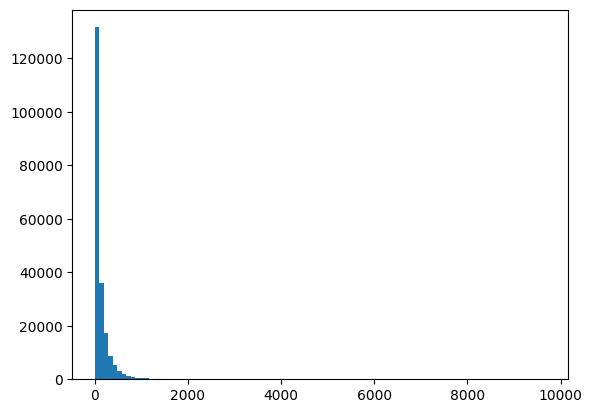

In [9]:
import matplotlib.pyplot as plt

plt.hist(post_lengths, bins=100)
plt.show()

### Building the Classifier

#### Spliting the dataset (again)

In [10]:
strat_train_set, strat_val_set = train_test_split(posts, test_size=1/9, random_state=1)

strat_train_set[:5]

,text,class
185289,Need some advice I’d appreciate if people won’...,0
135507,"Dear Magic Eye Bot I hate you,\nI never wanna ...",0
213617,If there's any teachers in this sub Why do you...,0
137338,I am now officially closer to 30 years of age ...,0
20632,Sure the royal family racism thing is interest...,0


#### Tokenizing the posts

In [32]:
import spacy

nlp = spacy.load('en_core_web_trf', disable=['transformer', 'parser', 'ner'])
nlp.pipe_names

['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [43]:
for doc in nlp.pipe(["some text", "some other text"]):
    print(doc._.trf_data.last_hidden_layer_state)

Ragged(data=array([[-0.70687133, -0.59165096,  0.24616808, ...,  1.5665028 ,
         0.1360929 , -0.92071015],
       [-0.6120827 , -1.4775716 , -0.88755137, ..., -0.22585   ,
         0.876766  , -0.04081748]], dtype=float32), lengths=array([1, 1]), data_shape=(-1, 768), starts_ends=None)
Ragged(data=array([[-0.762537  , -0.8032595 ,  0.02780165, ...,  1.8398607 ,
         0.03993908, -0.9114445 ],
       [ 0.15094262,  0.5576442 , -0.35056505, ...,  2.3292165 ,
         0.7934009 ,  0.79427475],
       [-0.4022416 , -1.6063384 , -0.89673215, ..., -0.11787412,
         0.80402535,  0.2646465 ]], dtype=float32), lengths=array([1, 1, 1]), data_shape=(-1, 768), starts_ends=None)


In [24]:
doc = nlp('I was reading the paper.')
print([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

['reading', 'paper']


In [25]:
def preprocess_set(set):
    texts = set.copy()['text']
    labels = set.copy()['class']
    texts = [' '.join(text.split()[:500]) for text in texts]

    docs = (doc for doc in (nlp.pipe(texts)))
    processed_texts = []
    for doc in docs:
        lemmas = [token.lemma_ for token in doc if not token.is_stop]
        processed_texts.append(' '.join(lemmas))
    
    return processed_texts, labels

In [26]:
len(strat_train_set)

185658

In [27]:
processed_texts, labels = preprocess_set(strat_train_set[:100])

In [ ]:
processed_val_texts, val_labels = preprocess_set(strat_val_set)

#### Creating the Tokenizer

In [ ]:
from keras_preprocessing.text import Tokenizer       # type: ignore

tokenizer = Tokenizer(num_words=3000, oov_token='<UNK>')
tokenizer.fit_on_texts(processed_texts)

In [ ]:
sequences = tokenizer.texts_to_sequences(processed_texts)

In [ ]:
sequence_lengths = [len(sequence) for sequence in sequences if len(sequence) < 1000]

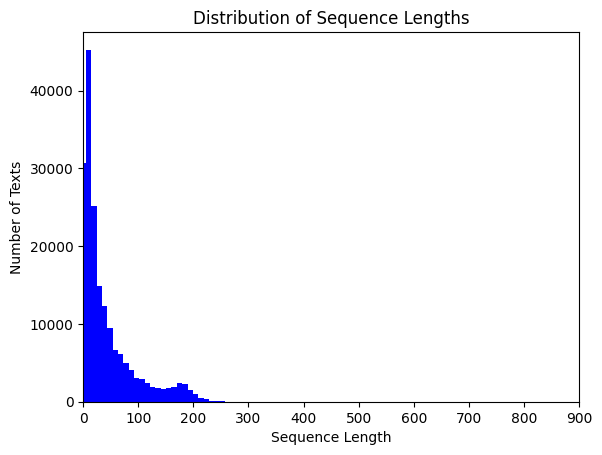

In [ ]:
plt.hist(sequence_lengths, bins=100, color='blue', align='left')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Texts')
plt.title('Distribution of Sequence Lengths')
plt.xlim(0, 200)
plt.xticks(range(0, max(sequence_lengths) + 1, 100))
plt.show()

In [ ]:
from keras.preprocessing.sequence import pad_sequences

max_len=200

def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len)
    return padded

padded_train_seq = get_sequences(tokenizer, processed_texts)
train_labels = np.array(labels)

In [ ]:
word_index = tokenizer.word_index

sorted(word_index.items(), key=lambda x: x[1])[:10]

[('<UNK>', 1),
 ('like', 2),
 ('want', 3),
 ('feel', 4),
 ('know', 5),
 ('life', 6),
 ('go', 7),
 ('think', 8),
 ('time', 9),
 ('people', 10)]

#### Creating the model

In [ ]:
Sequential = keras.models.Sequential

model = Sequential([
        keras.layers.Embedding(3000, 16),
    keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(20)),
    keras.layers.Dense(2, activation='sigmoid')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
padded_train_seq

array([[  27,  243,  547, ...,    0,    0,    0],
       [1700, 2253,  365, ...,    0,    0,    0],
       [ 301,  416,   52, ...,    0,    0,    0],
       ...,
       [ 343,    5,  187, ...,    0,    0,    0],
       [ 190,    6,   46, ...,    0,    0,    0],
       [   5,   63,  524, ...,    0,    0,    0]])

In [ ]:
len(processed_val_texts)

23208

In [ ]:
val_seq = get_sequences(tokenizer, processed_val_texts)
val_labels = np.array(val_labels)


h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 237s 40ms/step - accuracy: 0.9029 - loss: 0.2365 - val_accuracy: 0.9348 - val_loss: 0.1749
Epoch 2/20
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 257s 44ms/step - accuracy: 0.9405 - loss: 0.1566 - val_accuracy: 0.9383 - val_loss: 0.1691
Epoch 3/20
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 243s 42ms/step - accuracy: 0.9457 - loss: 0.1448 - val_accuracy: 0.9389 - val_loss: 0.1601
Epoch 4/20
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 226s 39ms/step - accuracy: 0.9495 - loss: 0.1343 - val_accuracy: 0.9406 - val_loss: 0.1573
Epoch 5/20
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 238s 41ms/step - accuracy: 0.9523 - loss: 0.1272 - val_accuracy: 0.9415 - val_loss: 0.1568
Epoch 6/20
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 268s 46ms/step - accuracy: 0.9551 - loss: 0.1183 - val_accuracy: 0.9404 - val_loss: 0.1569
Epoch 7/20
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 292s 50ms/step - accuracy: 0.9582 - loss: 0.1112 - val_accuracy: 0.9396 - val_loss: 0.1632


### Evaluating the Model

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 16)        │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 40)        │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            82 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,288 (747.22 KB)

 Trainable params: 63,762 (249.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 127,526 (498.15 KB)

In [ ]:
processed_test_texts, test_labels = preprocess_set(strat_test_set)

test_seq = get_sequences(tokenizer, processed_test_texts)
test_labels = np.array(test_labels)

In [ ]:
test_seq, test_labels

(array([[   5,  333,   59, ...,    0,    0,    0],
        [  38, 1265,   38, ...,    0,    0,    0],
        [2041,    1,  208, ...,    0,    0,    0],
        ...,
        [ 563,  356, 2214, ...,    0,    0,    0],
        [  53,    1,  164, ...,    0,    0,    0],
        [  64,    9,   12, ...,    0,    0,    0]]),
 array([1, 0, 0, ..., 0, 1, 1], dtype=int16))

In [ ]:
_ = model.evaluate(test_seq, test_labels)

726/726 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9434 - loss: 0.1549


In [ ]:
y_pred = model.predict(test_seq)
y_pred = (y_pred > 0.5).astype(int)

y_pred = np.array(list(map(lambda x: x[1], y_pred)))

726/726 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

False Positive Rate: 0.0550
False Negative Rate: 0.0631


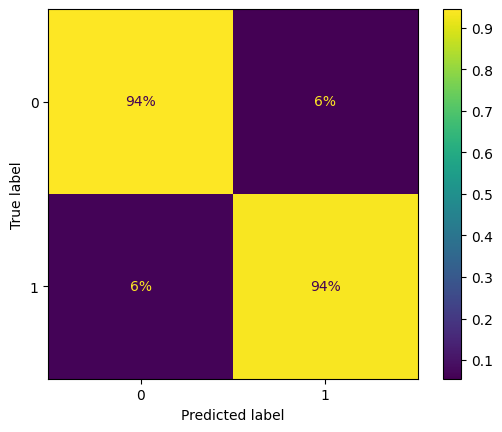

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()